In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import itertools

pitch = pd.read_csv("Coding/savant_pitch_level.csv")

In [5]:
count = pitch.groupby('pitch_type').size()
count

pitch_type
CH    238073
CS       303
CU    160681
EP      1165
FA      3245
FC    156820
FF    717343
FO       778
FS     38096
KC     42931
KN       278
PO       120
SC        75
SI    329169
SL    377443
ST     61387
SV      7422
dtype: int64

In [6]:
# choosing what pitch types based on count

pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST']
handedness = ['R', 'L']

In [7]:
# stats used for clustering 

stats = ['pfx_x', 'pfx_z', 'release_spin_rate', 'release_speed']

In [8]:
# creating a pitch ID and making sure there aren't duplicates

pitch['pitch_id'] = (
    pitch['game_pk'].astype(str) + '_' +
    pitch['pitcher'].astype(str) + '_' +
    pitch['batter'].astype(str) + '_' +
    pitch['pitch_number_appearance'].astype(str) 
)

duplicate_pitch_ids = pitch['pitch_id'].duplicated(keep=False)
duplicates = pitch[duplicate_pitch_ids]

In [9]:
duplicates

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,spin_axis,delta_home_win_exp,delta_run_exp,role_key,sp_indicator,rp_indicator,pitch_number_appearance,pitcher_at_bat_number,times_faced,pitch_id


In [10]:
def create_df(pitch_type, handedness, original_df):
    filtered_df = original_df.loc[(original_df['pitch_type'] == pitch_type) & (original_df['p_throws'] == handedness)]
    
    filtered_df = filtered_df[['pfx_x', 'pfx_z', 'release_spin_rate', 'release_speed', 
                            'pitch_id']].dropna(subset=['pfx_x', 'pfx_z', 'release_spin_rate', 'release_speed'])
    
    return filtered_df

In [11]:
def create_scaler(df):
    stats = df[['pfx_x', 'pfx_z', 'release_spin_rate', 'release_speed']]
    scaler = StandardScaler()

    stats_scaled = scaler.fit_transform(stats)
    
    temp_df = pd.DataFrame(stats_scaled, columns = stats.columns)

    df_reset = df.reset_index(drop = True)

    df_scaled = pd.concat([df_reset[['pitch_id']], temp_df], axis = 1)

    return df_scaled

In [12]:
def create_elbow_plot(X, handedness, max_clusters=10, save_fig=False, filename=None):
    numerical_X = X.select_dtypes(include = 'float64')
    
    distortions = []
    K = range(1, max_clusters + 1)

    for k in K:
        kmeans = KMeans(n_clusters = k, n_init = 10)
        kmeans.fit(numerical_X)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()

In [ ]:
for hand in handedness:
    for pitch_type in pitch_types:
            
        df = create_df(pitch_type, hand, pitch)
            
        if not df.empty:
            df_scaled = create_scaler(df)
            print(f"Elbow Plot for {pitch_type} {hand}")
            create_elbow_plot(df_scaled, hand)

In [13]:
# number of clusters for each pitch type based off of elbow plots

r_clust = {'FF': 3, 'SL': 4, 'CU': 4, 'SI': 4, 'CH': 4,'FS': 3,'KC': 3,'FC': 3, 'ST': 3}
l_clust = {'FF': 3, 'SL': 4, 'CU': 4, 'SI': 3, 'CH': 4,'FS': 3,'KC': 3,'FC': 3,'ST': 4}

In [15]:
# adding what cluster each pitch is in back to df

def add_cluster_labels(num_clusters, original_df):
    for pitch_type in pitch_types:

        pitch_data = original_df[original_df['pitch_type'] == pitch_type].dropna(subset=stats).copy()
        X = pitch_data[stats]
    
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kmeans = KMeans(n_clusters=num_clusters[pitch_type], n_init=10, random_state=42)
        labels = kmeans.fit_predict(X_scaled)

        original_df.loc[pitch_data.index, 'cluster'] = labels


In [16]:
right = pitch[pitch['p_throws'] == "R"].copy()
left = pitch[pitch['p_throws'] == "L"].copy()
add_cluster_labels(r_clust, right)
add_cluster_labels(l_clust, left)

In [18]:
# creating a new df with only the rows that have a value for cluster

r_pitch = right.dropna(subset=['cluster']).copy() 
r_pitch.loc[:, 'cluster'] = r_pitch['cluster'].astype(int)  
r_pitch.loc[:, 'pitch_cluster'] = r_pitch['pitch_type'].astype(str) + '_' + r_pitch['cluster'].astype(str)

In [19]:
l_pitch = left.dropna(subset=['cluster']).copy()
l_pitch.loc[:, 'cluster'] = l_pitch['cluster'].astype(int)  
l_pitch.loc[:, 'pitch_cluster'] = l_pitch['pitch_type'].astype(str) + '_' + l_pitch['cluster'].astype(str)

In [20]:
# adding columns and creating a df for comparison across clusters

r_pitch['ground_ball'] = np.where(r_pitch['bb_type'].notnull() & (r_pitch['bb_type'] == "ground_ball"), 1, 0)
r_pitch['popup'] = np.where(r_pitch['bb_type'].notnull() & (r_pitch['bb_type'] == "popup"), 1, 0)
r_pitch['sw_str'] = np.where(r_pitch['description'].notnull() & (r_pitch['description'] == "swinging_strike"), 1, 0)
r_pitch['weak_contact'] = np.where(r_pitch['launch_speed_angle'].notnull() & r_pitch['launch_speed_angle'].isin([1, 2, 3, 4]), 1, 0)

r_cluster_stats = r_pitch.groupby(['pitch_type', 'pitch_cluster']).agg({
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean',
    'woba_value': 'mean',
    'ground_ball': 'mean',
    'popup': 'mean',
    'sw_str': 'mean',
    'weak_contact': 'mean'
}).reset_index()

r_cluster_stats['ground_ball'] *= 100
r_cluster_stats['popup'] *= 100
r_cluster_stats['sw_str'] *= 100
r_cluster_stats['weak_contact'] *= 100
r_cluster_stats['pfx_x'] *= 12
r_cluster_stats['pfx_z'] *= 12

In [22]:
l_pitch['ground_ball'] = np.where(l_pitch['bb_type'].notnull() & (l_pitch['bb_type'] == "ground_ball"), 1, 0)
l_pitch['popup'] = np.where(l_pitch['bb_type'].notnull() & (l_pitch['bb_type'] == "popup"), 1, 0)
l_pitch['sw_str'] = np.where(l_pitch['description'].notnull() & (l_pitch['description'] == "swinging_strike"), 1, 0)
l_pitch['weak_contact'] = np.where(l_pitch['launch_speed_angle'].notnull() & l_pitch['launch_speed_angle'].isin([1, 2, 3, 4]), 1, 0)

l_cluster_stats = l_pitch.groupby(['pitch_type', 'pitch_cluster']).agg({
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean',
    'woba_value': 'mean',
    'ground_ball': 'mean',
    'popup': 'mean',
    'sw_str': 'mean',
    'weak_contact': 'mean'
}).reset_index()

l_cluster_stats['ground_ball'] *= 100
l_cluster_stats['popup'] *= 100
l_cluster_stats['sw_str'] *= 100
l_cluster_stats['weak_contact'] *= 100
l_cluster_stats['pfx_x'] *= 12
l_cluster_stats['pfx_z'] *= 12

In [23]:
# Adding a pitch cluster to a pitcher's arsenal if they threw that pitch
# then iterating over each possible pair and calculating the mean stats for every pitcher that had that pair of clusters in their arsenal

r_pitch_clusters = list(r_pitch['pitch_cluster'].unique())

r_pairs = list(itertools.combinations(r_pitch_clusters, 2))

r_all_pitches = r_pitch.groupby('pitcher')['pitch_cluster'].agg(lambda x: sorted(set(x))).reset_index().rename(columns={'pitch_cluster': 'all_pitches'})

r_pitch = pd.merge(r_all_pitches, r_pitch, on = 'pitcher', how = 'left')

r_pair_stats = []

for pair in r_pairs:
    sorted_pair = sorted(pair)
    selected_rows = r_pitch[r_pitch['all_pitches'].apply(lambda x: all(item in x for item in sorted_pair))]
    
    if not selected_rows.empty:
        mean_woba_value = selected_rows['woba_value'].mean()
        mean_ground_ball = selected_rows['ground_ball'].mean()
        mean_popup = selected_rows['popup'].mean()
        mean_sw_str = selected_rows['sw_str'].mean()
        mean_weak_contact = selected_rows['weak_contact'].mean()
        
        r_pair_stats.append({'combination': pair, 
                           'mean_woba_value': mean_woba_value,
                           'mean_ground_ball': mean_ground_ball,
                           'mean_popup': mean_popup,
                           'mean_sw_str': mean_sw_str,
                           'mean_weak_contact': mean_weak_contact})


r_pair_stats_df = pd.DataFrame(r_pair_stats).sort_values(by = 'mean_woba_value', ascending = False)

In [ ]:
l_pitch_clusters = list(l_pitch['pitch_cluster'].unique())

l_pairs = list(itertools.combinations(l_pitch_clusters, 2))


l_all_pitches = l_pitch.groupby('pitcher')['pitch_cluster'].agg(lambda x: sorted(set(x))).reset_index().rename(columns={'pitch_cluster': 'all_pitches'})


l_pitch = pd.merge(l_all_pitches, l_pitch, on = 'pitcher', how = 'left')


l_pair_stats = []


for pair in l_pairs:
    sorted_pair = sorted(pair)
    selected_rows = l_pitch[l_pitch['all_pitches'].apply(lambda x: all(item in x for item in sorted_pair))]
    
    if not selected_rows.empty:
        mean_woba_value = selected_rows['woba_value'].mean()
        mean_ground_ball = selected_rows['ground_ball'].mean()
        mean_popup = selected_rows['popup'].mean()
        mean_sw_str = selected_rows['sw_str'].mean()
        mean_weak_contact = selected_rows['weak_contact'].mean()
        
        l_pair_stats.append({'combination': pair, 
                           'mean_woba_value': mean_woba_value,
                           'mean_ground_ball': mean_ground_ball,
                           'mean_popup': mean_popup,
                           'mean_sw_str': mean_sw_str,
                           'mean_weak_contact': mean_weak_contact})



l_pair_stats_df = pd.DataFrame(l_pair_stats).sort_values(by = 'mean_woba_value', ascending = False)

l_pair_stats_df.sort_values(by = 'mean_woba_value', ascending = False)


In [26]:
l_pair_stats_df.to_csv('l_pair_stats.csv', index = False)
r_pair_stats_df.to_csv('r_pair_stats.csv', index = False)

r_cluster_stats.to_csv('r_cluster_stats.csv', index = False)
l_cluster_stats.to_csv('l_cluster_stats.csv', index = False)

In [54]:
# code to plot the cluster means for each stat that was used to cluster them

def plot_cluster_means(df, label, marker, linestyle, color, x_axis, y_axis):
    x = df[x_axis]
    y = df[y_axis]
    
    if len(x) > 0:
        x = np.append(x, x.iloc[0])
        y = np.append(y, y.iloc[0])
    
    plt.scatter(x, y, marker = marker, color = color, label = label)
    
    plt.plot(x, y, linestyle = linestyle, color = color)

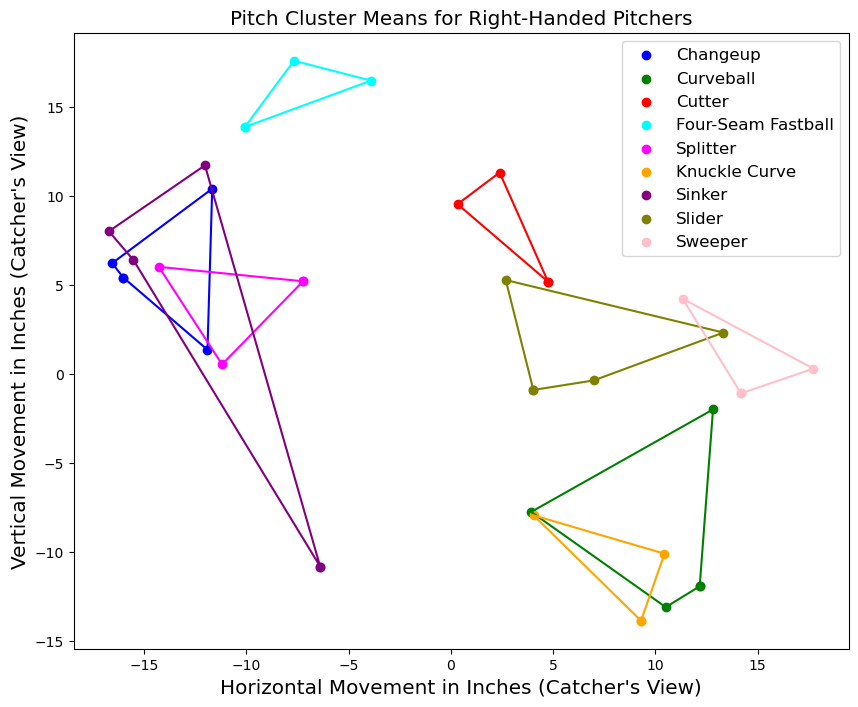

In [600]:
pitch_type_to_name = {
    'CH': 'Changeup',
    'CU': 'Curveball',
    'FC': 'Cutter',
    'FF': 'Four-Seam Fastball',
    'FS': 'Splitter',
    'KC': 'Knuckle Curve',
    'SI': 'Sinker',
    'SL': 'Slider',
    'ST': 'Sweeper'
}

r_cluster_stats_plot = r_cluster_stats.replace({'pitch_type': pitch_type_to_name})

# Define custom colors and pitch type order
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'purple', 'olive', 'pink']
pitch_types = r_cluster_stats_plot['pitch_type'].unique()
color_map = dict(zip(pitch_types, colors))
manual_cluster_order_SI = ['SI_3', 'SI_1', 'SI_0', 'SI_2']
manual_cluster_order_SL = ['SL_0', 'SL_3', 'SL_1', 'SL_2']


plt.figure(figsize=(10, 8))


for pitch_type in pitch_types:
    pt_mean_stats = r_cluster_stats_plot[r_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey')  
    

    if pitch_type == 'Sinker':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_SI,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    elif pitch_type == 'Slider':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_SL,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
    

    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color = color, x_axis = "pfx_x", y_axis = "pfx_z")
    

plt.legend(fontsize = 'large')
plt.xlabel("Horizontal Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.ylabel("Vertical Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Right-Handed Pitchers', fontsize = 'x-large')


plt.savefig('rhp_cluster_plot.png')


plt.show()

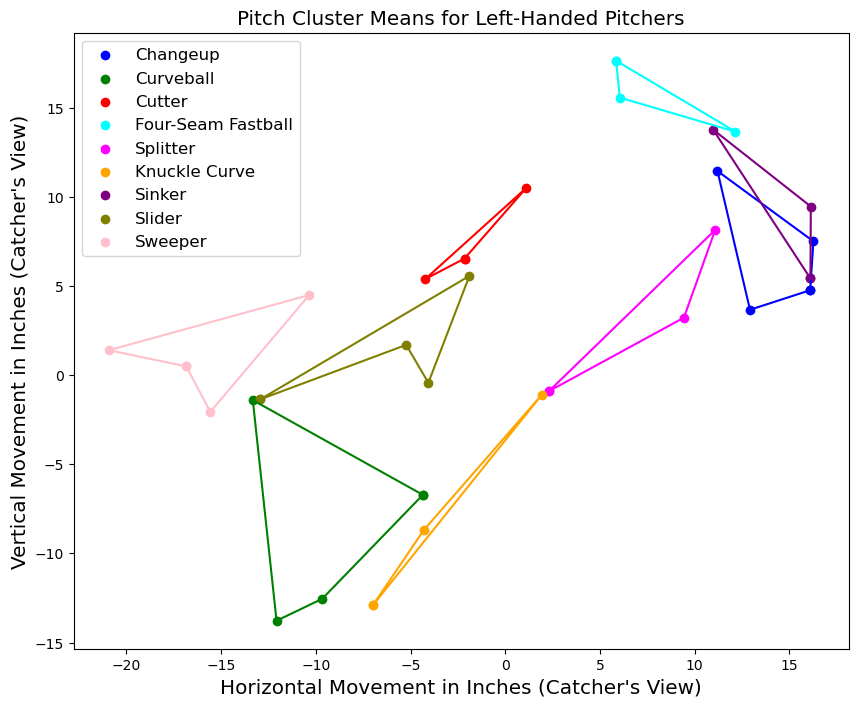

In [601]:
pitch_type_to_name = {
    'CH': 'Changeup',
    'CU': 'Curveball',
    'FC': 'Cutter',
    'FF': 'Four-Seam Fastball',
    'FS': 'Splitter',
    'KC': 'Knuckle Curve',
    'SI': 'Sinker',
    'SL': 'Slider',
    'ST': 'Sweeper'
}


l_cluster_stats_plot = l_cluster_stats.replace({'pitch_type': pitch_type_to_name})

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange', 'purple', 'olive', 'pink']
color_map = dict(zip(pitch_types, colors))

manual_cluster_order = ['SI_3', 'SI_1', 'SI_0', 'SI_2']
manual_cluster_order_cu = ['CU_3', 'CU_2', 'CU_0', 'CU_1']


pitch_types = l_cluster_stats_plot['pitch_type'].unique()


color_map = dict(zip(pitch_types, colors))

plt.figure(figsize = (10, 8))  


for pitch_type in pitch_types:
    pt_mean_stats = l_cluster_stats_plot[l_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey') 

    if pitch_type == 'Sinker':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    elif pitch_type == 'Curveball':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_cu,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
    

    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color = color, x_axis = "pfx_x", y_axis = "pfx_z")


plt.legend(fontsize = 'large')
plt.xlabel("Horizontal Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.ylabel("Vertical Movement in Inches (Catcher's View)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Left-Handed Pitchers', fontsize = 'x-large')
plt.savefig('lhp_cluster_plot.png')
plt.show()



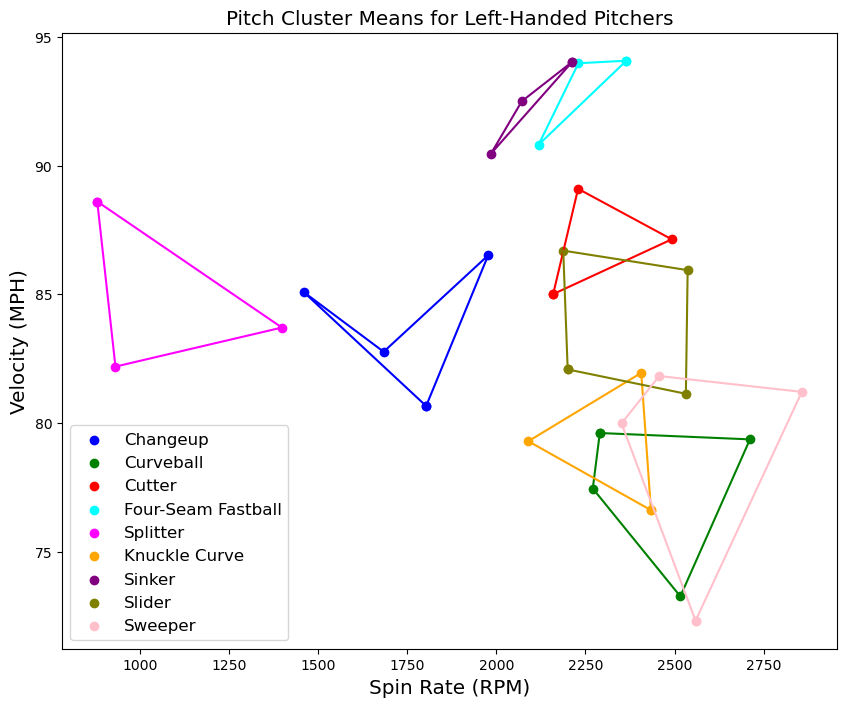

In [602]:
plt.figure(figsize=(10, 8))

manual_cluster_order_st = ['ST_3', 'ST_0', 'ST_2', 'ST_1']
manual_cluster_order_cu = ['CU_3', 'CU_2', 'CU_0', 'CU_1']
manual_cluster_order_sl = ['SL_2', 'SL_0', 'SL_3', 'SL_1']


for pitch_type in pitch_types:
    pt_mean_stats = l_cluster_stats_plot[l_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey')  

    if pitch_type == 'Slider':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_sl,
            ordered = True)
        pt_mean_stats.sort_values(by='pitch_cluster', inplace = True)
        
    elif pitch_type == 'Curveball':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_cu,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    elif pitch_type == 'Sweeper':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_st,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color = color, x_axis = "release_spin_rate", y_axis = "release_speed")

plt.legend(fontsize = 'large')
plt.xlabel("Spin Rate (RPM)", fontsize = 'x-large')
plt.ylabel("Velocity (MPH)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Left-Handed Pitchers', fontsize = 'x-large')


plt.savefig('lhp_sr_velo_plot.png')
plt.show()


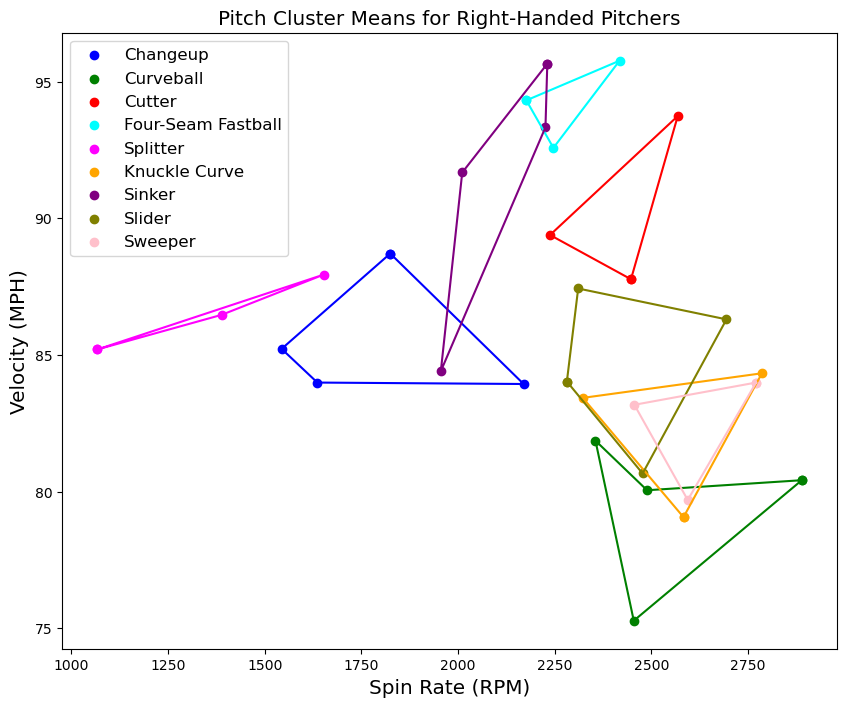

In [603]:
plt.figure(figsize=(10, 8))


manual_cluster_order_si = ['SI_0', 'SI_2', 'SI_3', 'SI_1']


for pitch_type in pitch_types:
    pt_mean_stats = r_cluster_stats_plot[r_cluster_stats_plot['pitch_type'] == pitch_type].copy()
    color = color_map.get(pitch_type, 'grey')  

    if pitch_type == 'Sinker':
        pt_mean_stats['pitch_cluster'] = pd.Categorical(
            pt_mean_stats['pitch_cluster'],
            categories = manual_cluster_order_si,
            ordered = True)
        pt_mean_stats.sort_values(by = 'pitch_cluster', inplace = True)
        
    plot_cluster_means(pt_mean_stats, pitch_type, marker = 'o', linestyle = '-', color=color, x_axis = "release_spin_rate", y_axis = "release_speed")

plt.legend(fontsize = 'large')
plt.xlabel("Spin Rate (RPM)", fontsize = 'x-large')
plt.ylabel("Velocity (MPH)", fontsize = 'x-large')
plt.title('Pitch Cluster Means for Right-Handed Pitchers', fontsize = 'x-large')


plt.savefig('rhp_sr_velo_plot.png')
plt.show()


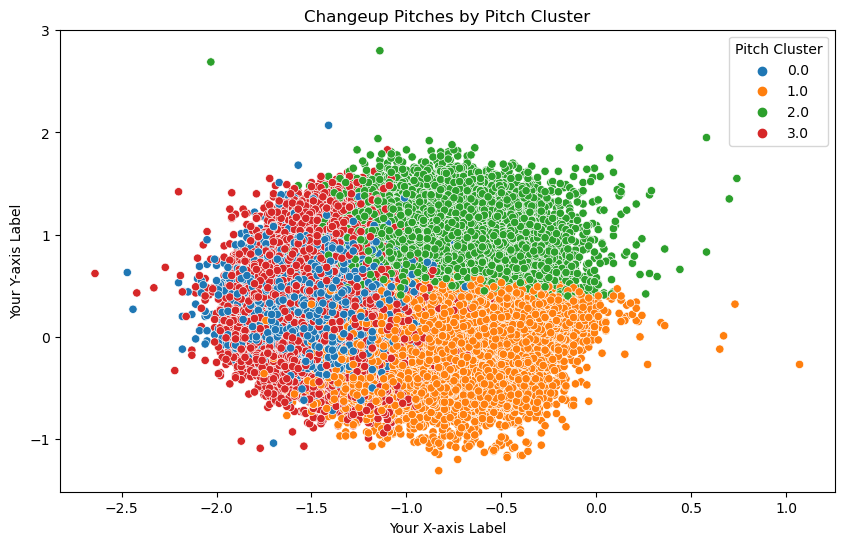

In [21]:
# visualizing the clusters

ch_pitches = right[right['pitch_type'] == 'CH']

plt.figure(figsize=(10, 6)) 

scatter = sns.scatterplot(data=ch_pitches, x='pfx_x', y='pfx_z', hue='cluster', palette='tab10', legend='full')


plt.title('Changeup Pitches by Pitch Cluster')

plt.legend(title='Pitch Cluster')

plt.show()

